### Gaussian copula with only location matrix ie: a single kernel

In [3]:
from scipy.optimize import dual_annealing
import numpy as np
import itertools
from scipy.optimize import Bounds
from scipy.optimize import minimize
import scipy.stats as scs
from pynverse import inversefunc
from math import sqrt
from scipy.special import gamma
from scipy.special import kv 
from  geopy.geocoders import Nominatim
from itertools import combinations
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import Matern
from collections import Counter
from statsmodels.distributions.empirical_distribution import ECDF

In [4]:
#makes the banana density region shift with most sigmas!

#first class is with sigma allowed to change - not used yet
class norm_cop_loconly():

    def __init__(self,L=np.array([[0,1,1],[1,0,1],[1,1,0]])):
        '''
        L is location matrix: n x n
        '''
        self.N=L.shape[0]
        self.L=L

    def sim(self,theta,draws=3,as_x=True):
        '''
        Returns: [ [m [draws of length n] for day t+1],..., [m [draws of length n] for day t+T_(depending on prediction matricies X_all)] ]
        So to get the samples from day t+1: sim[1-1]
        To get k th draw from samples at day t+T: sim[T-1][k-1]
        To get u for 3rd location of kth drw for day T: sim[T-1][k-1][3-1]'''
        cov_mat=Matern(length_scale=theta[1],nu=theta[2]).__call__(self.L) *np.power(theta[0],2)  
        if as_x==True:
            return [scs.multivariate_normal.rvs(mean=np.zeros(self.N),cov=cov_mat) for i in range(draws) ] 
        if as_x==False:
            Us=[np.zeros(self.N) for i in range(draws)] 
            for i in range(draws):
                Us[i]=[scs.multivariate_normal.cdf(y,mean=0,cov=cov_mat[idx,idx]) for idx,y in enumerate(scs.multivariate_normal.rvs(mean=np.zeros(self.N),cov=cov_mat))]
            return Us

    
    def nll(self,theta,data):
        '''
        theta: [sigma,p0,v0,p1,v1] vector of parameters for the Matern Kernel
        data: [[u1,..,un],...,[...]] one set of (n: one for each location) us for each day 1 to T (T is the number of predictor matricies).
        '''
        nll=0
        cov_mat=Matern(length_scale=theta[1],nu=theta[2]).__call__(self.L) *np.power(theta[0],2) 

        for day in range(len(data)):
            #nll for the copula density: joint and marginals
            nll+=scs.multivariate_normal.logpdf([scs.norm.ppf(obs,loc=0,scale=cov_mat[idx,idx]) for idx,obs in enumerate(data[day])],mean=np.zeros(self.N),cov=cov_mat) 
            nll+=-np.sum([scs.norm.logpdf(obs,loc=0,scale=cov_mat[idx,idx]) for idx,obs in enumerate(data[day])])
        return -nll


# This class is with sigma fixed at 1 - This is what is used for the rest of this notebook
class norm_cop_loconly():

    def __init__(self,L=np.array([[0,1,1],[1,0,1],[1,1,0]])):
        '''
        L is location matrix: n x n
        '''
        self.N=L.shape[0]
        self.L=L

    def sim(self,theta,draws=3,as_x=True):
        '''
        Returns: [ [m [draws of length n] for day t+1],..., [m [draws of length n] for day t+T_(depending on prediction matricies X_all)] ]
        So to get the samples from day t+1: sim[1-1]
        To get k th draw from samples at day t+T: sim[T-1][k-1]
        To get u for 3rd location of kth drw for day T: sim[T-1][k-1][3-1]'''
        cov_mat=Matern(length_scale=theta[0],nu=theta[1]).__call__(self.L) *np.power(1,2)  
        #sigma should be in theta ##############################

        if as_x==True:
            return [scs.multivariate_normal.rvs(mean=np.zeros(self.N),cov=cov_mat) for i in range(draws) ] 
        if as_x==False:
            Us=[np.zeros(self.N) for i in range(draws)] 
            for i in range(draws):
                Us[i]=[scs.multivariate_normal.cdf(y,mean=0,cov=cov_mat[idx,idx]) for idx,y in enumerate(scs.multivariate_normal.rvs(mean=np.zeros(self.N),cov=cov_mat))]
            return Us

    
    def nll(self,theta,data):
        '''
        theta: [sigma,p0,v0,p1,v1] vector of parameters for the Matern Kernel
        data: [[u1,..,un],...,[...]] one set of (n: one for each location) us for each day 1 to T (T is the number of predictor matricies).
        '''
        nll=0
        cov_mat=Matern(length_scale=theta[0],nu=theta[1]).__call__(self.L) *np.power(1,2) 
        #sigma should be in theta ##############################

        for day in range(len(data)):
            #nll for the copula density: joint and marginals
            nll+=scs.multivariate_normal.logpdf([scs.norm.ppf(obs,loc=0,scale=cov_mat[idx,idx]) for idx,obs in enumerate(data[day])],mean=np.zeros(self.N),cov=cov_mat) 
            nll+=-np.sum([scs.norm.logpdf(obs,loc=0,scale=cov_mat[idx,idx]) for idx,obs in enumerate(data[day])])
        return -nll
        

### Getting marginals and rain values

In [5]:
model_version = 1
target_distribution = "gamma_hurdle"
base_nn = "HLSTM" #(Keep this fixed)
cities=sorted(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
             'NorahHead', 'NorfolkIsland',  'Richmond',
            'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
            'Wollongong', 'Canberra', 'Tuggeranong',  'Ballarat',
            'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
            'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
            'Woomera', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
            'Perth',  'Walpole', 'Hobart', 
            'AliceSprings', 'Darwin', 'Uluru'])
#had to remove 'Albany' , 'Katherine','Launceston','MountGinini','Newcastle','Penrith','SalmonGums',
sys.path.append('../')
import glms
import pickle
import torch
path_ = f"../Checkpoints/DGLM_{base_nn}_{target_distribution}/lightning_logs/version_{model_version}/"
ckpt_path = glms.NeuralDGLM.get_ckpt_path(os.path.join(path_,"checkpoints"))
scaler_features, scaler_target = glms.NeuralDGLM.load_scalers(path_)
model = glms.NeuralDGLM.load_from_checkpoint(ckpt_path, save_hparams=False, scaler_features=scaler_features, scaler_target=scaler_target)
model.freeze()
model.eval()
test_output = pickle.load( open(os.path.join(path_,"test_output.pkl"),"rb") )
# Gamma allcities contains all parameter values, rain and dates for all locations
gamma_allcities=[]
for i,location in enumerate(cities):
    city_data = test_output[location] 
    city_data.keys()
    day_idx = 2
    pred_mu = city_data['pred_mu'][:,day_idx] #.shape
    pred_p = city_data['pred_p'][:,day_idx] 
    pred_disp = city_data['pred_disp'][:, day_idx]
    target_rain_value = city_data['target_rain_value'][:,day_idx]
    dates = [ date_index[day_idx] for date_index in city_data['date'] if len(date_index)>day_idx]
    gamma_allcities.append([i,location,pred_mu,pred_disp,pred_p,target_rain_value,dates])
#create list with all dates
gamma_all_dates=[]
for i in [0,16,19]:
    for day in gamma_allcities[i][6]:
        gamma_all_dates.append(day)
#check which overlap and make a list of the dates that do
overlap_days=[i[0] for i in np.array(Counter(gamma_all_dates).most_common(402))]
index_for_overlapdays=[[],[],[]]
for idx,i in enumerate([0,16,19]):
    for day in overlap_days:
        if day in gamma_allcities[i][6]:
            index_for_overlapdays[idx].append(gamma_allcities[i][6].index(day))
#index_for_overlapdays : [[days at loc 1], [days loc2], [days loc3]]
g_us_pre=[[] , [] , []]
for idx,i in enumerate([0,16,19]):
    g_us_pre[idx]=[ (1-gamma_allcities[i][4][day]-np.power(0.1,2))+((gamma_allcities[i][4][day]+np.power(0.1,2))*scs.gamma(scale=1/(gamma_allcities[i][3][day]*gamma_allcities[i][2][day]),a=1/gamma_allcities[i][3][day]).cdf(gamma_allcities[i][5][day]) )for day in index_for_overlapdays[idx] ]
#Now g_us_pre is a list of F(rain) for loc [[0],[16],[19]]
#the following gets us to 402 days of [u1,u2,u3] ie [[u1,u2,u3]_day1, [u1,u2,u3]_day2, ... , [u1,u2,u3]_day402]
g_us=[]
for i in range(len(g_us_pre[0])):
    g_us.append([g_us_pre[0][i],g_us_pre[1][i],g_us_pre[2][i]])


C:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Distance matrix

In [6]:
loc_distmatrix=np.array([[0.0, 20.71654842910133, 8.395798672490209, 12.18087925970394, 12.189239066569014, 5.883269978205996, 5.970267569079828, 16.23820061159433, 19.38328712013618, 10.507831841438426, 8.006374526358497, 15.234808699788402, 4.01634983566602, 23.76972125953787, 16.353628994123948, 11.80900825804958, 21.422105084952705, 10.733790484078739, 6.9871239494439115, 6.808682226582339, 3.6393131707057087, 12.499496605635334, 3.626445094729428, 10.190473086106463, 13.331825486403286, 2.760266509928684, 13.071956744677594, 29.945614622766975, 0.6047732748149317, 10.49263723477266, 12.15138432115147, 22.933296127424427, 22.8286585170809, 4.550244785439073, 7.025524234090858, 9.041363143189162, 17.0673668090531, 12.662099234862076, 12.61923660604717, 17.698088967387992, 10.503769332184541, 12.210890445275922, 8.769836687573608, 21.868980919163562, 7.055672298238158, 11.769930203961591, 23.51675323602915, 12.304236676763756, 4.129055180280314], [20.71654842910133, 0.0, 29.051858892213833, 19.601351430265186, 32.880431373744784, 26.10059959191303, 26.455878326847387, 35.94304204880906, 33.24953809666179, 31.21885160162979, 28.172417313817363, 35.545836036326634, 
23.57184079342484, 26.02008381550556, 36.218303793679375, 30.474962650875902, 25.08993017718061, 29.947629498055957, 27.222842057705165, 27.079094190324472, 24.29341792265919, 32.43769976122779, 23.06894094784226, 30.893153285082796, 33.96125628885112, 23.42688338040208, 33.729241716373814, 50.43280329555711, 21.117598698839902, 31.201805554934392, 32.83527361077196, 3.678404983440583, 3.6308647150974656, 23.95195005268872, 27.262622523688552, 29.343301737021864, 4.279599266474838, 33.353372204385416, 33.31418837755677, 32.95707033796734, 31.211040862700624, 16.327729860505965, 29.484307827158997, 1.1535637536649759, 27.332347990780605, 30.43660374318458, 2.9568084968391495, 33.01570145808181, 19.324060816483346], [8.395798672490209, 29.051858892213833, 0.0, 17.97851769648043, 4.414459537716083, 3.3960564946072243, 2.7196563660184925, 10.55728223388457, 19.19393927867371, 2.3210091525320613, 4.708121112007093, 8.477221834448414, 5.9328388780475265, 28.571300847694037, 10.367444650529889, 6.814488782398519, 26.114104991203902, 5.358167156124952, 2.6116145411164173, 2.6181868434170177, 5.117842767948564, 7.236039042933819, 6.377422044843061, 1.9363334317916494, 5.8003723436041295, 5.643020398007282, 5.428606938362801, 22.192534756107875, 8.084544724441992, 2.283242557031892, 4.4383033681655775, 31.328918704549956, 31.224330077669695, 5.774838032990451, 2.5864669322801825, 2.029998862639867, 25.46162796792233, 4.842010565065319, 4.773574496773604, 16.823790835220574, 2.2736056893932686, 19.17152670434876, 1.0658310279075376, 30.2054114254689, 2.4529980830884646, 6.792097977672596, 31.882045103472187, 4.308558497836181, 11.209223119035752], [12.18087925970394, 19.601351430265186, 17.97851769648043, 0.0, 19.699129203264267, 17.081980905029017, 16.696211906190523, 19.5100358452495, 13.686889861634926, 19.136072101685897, 14.272949114066806, 20.332504547197328, 16.031782840992186, 11.641930820419484, 20.001862204986256, 23.427501822861664, 9.374405401040747, 22.142221174264414, 17.94615634828471, 17.750254143688473, 13.361949868206619, 16.968184853467655, 15.721696432928692, 19.01926874661088, 20.133860650007755, 13.918746004685953, 20.115942104069216, 34.49183833904343, 11.922755627868717, 19.16125658370658, 19.58901536198867, 19.821286869290326, 19.718878523068312, 16.558542084001825, 17.97533782907816, 19.52834366713751, 15.359995505555142, 20.091315908758748, 20.09990163463575, 13.683532232715402, 19.203877465147684, 3.2903430429430833, 17.669873063049117, 20.526923527748494, 17.94006445400942, 23.391113069335567, 21.43327704650249, 20.111550091122115, 8.05856105553911], [12.189239066569014, 32.880431373744784, 4.414459537716083, 19.699129203264267, 0.0, 7.805830873129257, 7.073204138011018, 6.805738872923808, 17.67473130665689, 2.1688576872299086, 5.4576197914088365, 4.297578452455821, 10.293803452063438, 29.240434145511315, 6.457346697253601, 9.627277730013365, 26.80584094281807, 8.369471965822775, 6.991776341020493, 7.01885996254853, 8.587015066588554, 4.511335478922667, 10.714094512232062, 2.569630418202482, 1.4135610587780165, 9.570863610403725, 1.0189908306496882, 17.88547120853121, 11.764948510279238, 2.2247230213177835, 0.13983071786593015, 34.936974883542085, 34.830683106368475, 10.171787729721812, 6.96276498776839, 5.601305666529542, 29.114139186765783, 0.47305388200436604, 0.43886872139322564, 15.141027299284055, 2.258024307069776, 21.480830964919893, 3.5945910803831995, 34.030810329626554, 6.834133533269561, 9.620402161866442, 35.64397948155176, 0.562991016189676, 14.174803579378054], [5.883269978205996, 26.10059959191303, 3.3960564946072243, 17.081980905029017, 7.805830873129257, 0.0, 0.9075245548748964, 13.632122374930695, 20.72996533328347, 5.709105427279195, 6.377140639743556, 11.76490562091709, 2.6089009335449527, 28.277399985168906, 13.515613636995049, 6.350476858628021, 25.84555564576776, 5.072276515163916, 1.1310079293730797, 0.9785396498353786, 3.7804038870945265, 10.06884464105457, 3.0897179169987323, 5.315996708108135, 9.179738565795734, 3.3010382844406396, 8.8161768096022, 25.564418351861285, 5.766356465791649, 5.667501031773731, 7.824548538904651, 28.55647529480921, 28.45383095928614, 2.388438095968711, 1.1707530536834498, 3.2498644907271013, 22.68395424189301, 8.237388017599699, 8.169410388740223, 18.54367823237949, 5.652839177181122, 17.715100476840522, 4.276661297371181, 27.252398525011316, 1.2320763248654825, 6.314677716498606, 28.976641197613052, 7.701530265127326, 9.48547249976479], [5.970267569079828, 26.455878326847387, 2.7196563660184925, 16.696211906190523, 7.073204138011018, 0.9075245548748964, 0.0, 12.755619845354762, 19.89405692413542, 5.035372975560334, 5.48466583490692, 10.943084493732396, 3.2233190620643457, 27.76849276267334, 12.651872650925794, 6.839161081248359, 25.327658508053197, 5.477880313237347, 1.2557534827728218, 1.062115613927269, 3.3348247146374845, 9.172852085127339, 3.6592375761790024, 4.655244241733653, 8.422975731914734, 3.242920892914559, 8.072478274805928, 24.90604460481361, 5.763008565320914, 5.00003550771776, 7.082029626355435, 28.825609342547747, 28.72201420106531, 3.1130998844663305, 1.2826184689167106, 3.0907547663574295, 22.95161976409697, 7.517446101269866, 7.45348298742293, 17.6854836929479, 4.992159850241288, 17.488406437344835, 3.4958110987175615, 27.609103540444465, 1.2442713101674483, 6.805643955145933, 29.30977135669916, 7.011314199741729, 9.301209115085983], [16.23820061159433, 35.94304204880906, 10.55728223388457, 19.5100358452495, 6.805738872923808, 13.632122374930695, 12.755619845354762, 0.0, 12.800321714992707, 8.756210859805403, 8.241255401253518, 2.8287055743163316, 15.724681215514122, 26.78277626265582, 0.6614224704862716, 16.43211913695474, 24.49666556187385, 15.154904811055138, 13.114619272348223, 13.079566547131115, 12.769603432206612, 3.7551528931651372, 16.03417257857373, 9.112933829461022, 5.590484118273566, 14.189140909506296, 5.992210640087349, 15.01647948663062, 15.679119076212114, 8.821877526903071, 6.700052248026396, 37.43252566576516, 37.324719248345666, 15.770266943095598, 13.095351399143432, 12.191478406932816, 31.86008493455122, 6.636600081977169, 6.722536408352925, 10.289401591244653, 8.870742714615515, 22.09332790039313, 9.510467165701435, 37.06110873309839, 12.95919373972105, 16.424865387320104, 38.48577239829147, 7.274156634244394, 16.62227086329071], [19.38328712013618, 33.24953809666179, 19.19393927867371, 13.686889861634926, 17.67473130665689, 20.72996533328347, 19.89405692413542, 12.800321714992707, 0.0, 18.676031620089873, 14.577800548751197, 15.257828706558877, 21.477632588526415, 15.583084104281888, 13.461453114252986, 26.008426324898508, 13.730042972387714, 24.551399505349693, 20.90920925815701, 20.767510778994605, 17.63739335069998, 13.184497848578234, 21.491376648504016, 18.849392081836378, 17.08930647778535, 19.080646326127397, 17.35716696321547, 25.27555030760134, 18.81225539560872, 18.736447830315498, 17.535356718164334, 
33.47644788261603, 33.375313729293, 21.826604144342742, 20.913897240252517, 21.2237688383274, 28.984886701206047, 17.787790636349197, 17.851878988093777, 2.5621065466589075, 18.795839466956554, 16.9771852983061, 18.26416479686641, 34.197161205326246, 20.801735346758274, 25.985996709570127, 35.119191673528164, 18.23765215634566, 16.850600705604215], [10.507831841438426, 31.21885160162979, 2.3210091525320613, 19.136072101685897, 2.1688576872299086, 5.709105427279195, 5.035372975560334, 8.756210859805403, 18.676031620089873, 0.0, 5.010637669165629, 6.411844100687181, 8.253177765399865, 29.23988897960778, 8.474964516181377, 7.789417488446342, 26.786562246112407, 6.443096462254043, 4.843277748109772, 4.881369889969464, 7.027446276492273, 5.882530597169168, 8.694609259012719, 0.4023475948189624, 3.5818157027683437, 7.79696757837929, 3.185533195133144, 19.87208112151368, 10.141246193097585, 0.06695534078473611, 2.2201419929749053, 33.40865455298531, 33.303284277929514, 8.092964160259205, 4.812932056472364, 3.468283257133679, 27.55483370500965, 2.5603930354103275, 2.4861245532304936, 16.20150175581219, 0.12372408498146342, 20.62853971428465, 1.7430795202492633, 32.37184208039756, 4.686782186062997, 7.7774050024904575, 34.02454799603367, 1.9939467867528358, 12.941755145081537], [8.006374526358497, 28.172417313817363, 4.708121112007093, 14.272949114066806, 5.4576197914088365, 6.377140639743556, 5.48466583490692, 8.241255401253518, 14.577800548751197, 5.010637669165629, 0.0, 7.377676029779499, 
7.876797036902606, 24.23310442133221, 8.347483269332894, 11.481747622688168, 21.77878261071411, 10.020810859391126, 
6.375698361953415, 6.249299999413041, 4.549714789368022, 4.494218446323949, 8.096274426732034, 4.988490409288746, 6.112547167066783, 6.024052570408414, 6.0042809637050665, 22.26166620084264, 7.457874560350485, 5.048383629964336, 5.356470988080008, 29.977408592563965, 29.87011124193957, 8.048607835581253, 6.376564630590332, 6.72028784436232, 24.235930088850914, 5.875290253221549, 5.87414362512635, 12.281321615143058, 5.098987797903095, 16.030044365788466, 3.928280709730974, 29.31067996338288, 6.257872611052068, 11.457070339512605, 30.837761851694946, 5.844605789153612, 9.01403229465938], [15.234808699788402, 35.545836036326634, 8.477221834448414, 20.332504547197328, 4.297578452455821, 11.76490562091709, 10.943084493732396, 2.8287055743163316, 15.257828706558877, 6.411844100687181, 7.377676029779499, 0.0, 14.080912575229618, 28.53382657248113, 2.313540868440864, 13.852258562050949, 26.179379884663522, 12.639866179580414, 11.088213713431307, 11.085412875268199, 11.620904692494147, 3.377534003310155, 14.447965005798748, 6.79946093903129, 2.942780447232085, 12.891606404329227, 3.3618619991350545, 14.899193207957357, 14.723404293879604, 6.473334169515014, 4.217726428483851, 37.289859338024975, 37.18230014235107, 14.044803957014532, 11.063519040637983, 9.877475670111922, 31.583947625027978, 4.0326605490556995, 4.119524225565111, 12.705311528800777, 6.514180111423696, 22.629345998529757, 7.498940024502724, 36.68247333564032, 10.929679344384043, 13.848049196861275, 38.1956249112724, 4.687070160428599, 16.313224894520825], [4.01634983566602, 23.57184079342484, 5.9328388780475265, 16.031782840992186, 10.293803452063438, 2.6089009335449527, 3.2233190620643457, 15.724681215514122, 21.477632588526415, 8.253177765399865, 7.876797036902606, 14.080912575229618, 0.0, 27.517643049149513, 15.676079658451746, 7.824417820188184, 25.12985463046289, 6.832176184964188, 3.688096930902266, 3.5660092022841234, 3.841353782157122, 12.038632532498436, 0.5042384507397505, 7.868628704464301, 11.63370033778259, 2.4514141749240665, 11.28915197226135, 28.12523690372876, 4.139519356755239, 8.216065982737224, 10.300032945116625, 26.10786997701887, 26.006372832526466, 0.5350711761661082, 3.72726020391859, 5.791011228354339, 20.244925593887316, 10.73992630148295, 10.676378940868537, 19.472476549554504, 8.20606793512401, 16.2216085421626, 6.7070173180353905, 24.72167275293523, 3.8128527458301815, 7.784975579787733, 26.46455666812734, 10.233645160253303, 8.062744285347], [23.76972125953787, 26.02008381550556, 28.571300847694037, 11.641930820419484, 29.240434145511315, 28.277399985168906, 27.76849276267334, 26.78277626265582, 15.583084104281888, 29.23988897960778, 24.23310442133221, 28.53382657248113, 27.517643049149513, 0.0, 27.40651246240861, 34.60239815809548, 2.457717552367694, 33.24216256309286, 29.021511669705195, 28.829789174648326, 24.49734395458928, 25.495704103806784, 27.24273914886828, 29.21871823197332, 29.274306750541232, 25.278849870241523, 29.378918548745236, 40.64773167273974, 23.470417554482164, 29.279337319297476, 29.110784098652143, 24.583857879719933, 24.50910440695744, 28.03370869462686, 29.046075986373417, 30.345595074238908, 22.48782052014457, 29.5444837830753, 29.576581784140664, 17.367950650372855, 29.33067418083806, 12.885839602733578, 28.042145478451086, 26.572905842934393, 28.9903812876328, 34.5681163690254, 26.69931395368955, 29.74105229937696, 19.671802540303343], [16.353628994123948, 36.218303793679375, 10.367444650529889, 20.001862204986256, 6.457346697253601, 13.515613636995049, 12.651872650925794, 0.6614224704862716, 13.461453114252986, 8.474964516181377, 8.347483269332894, 2.313540868440864, 15.676079658451746, 27.40651246240861, 0.0, 16.07680382555002, 25.11246007542978, 14.826147221493457, 12.94986853484377, 12.924374222651425, 12.838663549170294, 3.8603544545901434, 16.001871500685848, 8.843572635826757, 5.1816559011512995, 14.22664606926247, 5.593003517938983, 14.580315468893897, 15.804370758779521, 8.539569776396005, 6.359902738354991, 37.76131670892721, 37.65351038798058, 15.699287243188612, 12.92890989122661, 11.932470893182332, 32.15846228367525, 6.251633782305375, 6.338398539322258, 10.950763323366136, 8.585999390115813, 22.53929831584864, 9.335604126958279, 37.34087374631557, 12.793061993599686, 16.070901598740704, 38.78479149784264, 6.899023679695031, 16.89459485591352], [11.80900825804958, 30.474962650875902, 6.814488782398519, 23.427501822861664, 9.627277730013365, 6.350476858628021, 6.839161081248359, 16.43211913695474, 26.008426324898508, 7.789417488446342, 11.481747622688168, 13.852258562050949, 7.824417820188184, 34.60239815809548, 16.07680382555002, 0.0, 32.16390106298679, 1.460936968992133, 5.592908305560142, 5.781455130408701, 10.11608174854249, 13.653962252926949, 8.272446861335107, 7.493338483383898, 10.9124097975156, 9.549294193710258, 10.495277000084492, 24.85040787524232, 11.84232893782565, 7.722509753638039, 9.732074093172029, 33.3117555216395, 33.21456159636496, 7.30385389952008, 5.570766880035534, 4.784724922844002, 27.52646858190583, 9.829463747462727, 9.742495228547048, 23.630948576710207, 7.667215231922313, 23.93984152168767, 7.767610020942581, 31.601738771669833, 5.637571129722479, 0.03988384221772708, 33.4223430783546, 9.17900382271676, 15.709589312308676], [21.422105084952705, 25.08993017718061, 26.114104991203902, 9.374405401040747, 26.80584094281807, 25.84555564576776, 25.327658508053197, 24.49666556187385, 13.730042972387714, 26.786562246112407, 21.77878261071411, 26.179379884663522, 25.12985463046289, 2.457717552367694, 25.11246007542978, 32.16390106298679, 0.0, 30.79903444487072, 26.57974362518882, 26.388455628397928, 22.065152381048733, 23.105586992356976, 24.86474197031997, 26.763535744602848, 26.859764287476832, 22.870295587110363, 26.9579805604289, 38.55207296800249, 21.10653372452117, 26.825730981383263, 26.676835488616458, 23.976985873712756, 23.894972339585447, 25.64273588728671, 26.603992762762957, 27.891660304878354, 21.346039838663255, 27.114397532099822, 27.145453484330545, 15.328740451315195, 26.876916985439777, 10.949667306789854, 25.58465516471833, 25.73027858125777, 26.54708648150784, 32.12980871974037, 26.023712803850866, 27.303461226041584, 17.345887539364114], [10.733790484078739, 29.947629498055957, 5.358167156124952, 22.142221174264414, 8.369471965822775, 5.072276515163916, 5.477880313237347, 15.154904811055138, 24.551399505349693, 6.443096462254043, 10.020810859391126, 12.639866179580414, 6.832176184964188, 33.24216256309286, 14.826147221493457, 1.460936968992133, 30.79903444487072, 0.0, 4.22261887276405, 4.41577016806523, 8.79217273590942, 12.273777593582581, 7.308777870452909, 6.126633968876791, 9.698013407749809, 8.34005687789534, 9.278499762658205, 24.23668568459885, 10.715570309935348, 6.376202333220911, 8.466373559242346, 32.68239524428416, 32.583413264435606, 6.336716983940168, 4.197170779177106, 3.329836153266194, 26.858134529057555, 8.607227133381686, 8.520388126124633, 22.179356463819182, 6.322863636161858, 22.764638552561433, 6.323281239306453, 31.084253823909254, 4.251947982173582, 1.4365421648248455, 32.882152104320085, 7.952798871909435, 14.528435772110342], [6.9871239494439115, 27.222842057705165, 2.6116145411164173, 17.94615634828471, 6.991776341020493, 1.1310079293730797, 1.2557534827728218, 13.114619272348223, 20.90920925815701, 4.843277748109772, 6.375698361953415, 11.088213713431307, 3.688096930902266, 29.021511669705195, 12.94986853484377, 5.592908305560142, 26.57974362518882, 4.22261887276405, 0.0, 0.19621728553138015, 4.5844216914834774, 9.672370480780657, 4.181167101961976, 4.441961389183362, 8.391854314209299, 4.343077798460346, 8.010304824273522, 24.616599030889386, 6.842536391366945, 4.7948377741445745, 7.02520759613638, 29.687089782519323, 29.584478607994292, 3.4007065791500373, 0.039836454644710834, 2.1216553349674006, 23.814718210504974, 7.401387572626587, 7.328438394726154, 18.65033875143432, 4.7724229279217525, 18.696197144584826, 3.6149631490291507, 28.374292864092908, 0.15864252791353503, 5.559950077343197, 30.101959268299996, 6.831103699121304, 10.486797509338556], [6.808682226582339, 27.079094190324472, 2.6181868434170177, 17.750254143688473, 7.01885996254853, 0.9785396498353786, 1.062115613927269, 13.079566547131115, 20.767510778994605, 4.881369889969464, 6.249299999413041, 11.085412875268199, 3.5660092022841234, 28.829789174648326, 12.924374222651425, 5.781455130408701, 26.388455628397928, 4.41577016806523, 0.19621728553138015, 0.0, 4.388633668980912, 9.612392683236791, 4.054554659242169, 4.4815841852348814, 8.413544847940333, 4.154803139942772, 8.036250089394605, 24.685855952996167, 6.657746044501649, 4.834804866643831, 7.048515643401085, 29.53113638319746, 29.428392895333957, 3.2998076649534913, 0.22828448797740977, 2.273896806960391, 23.658157217909274, 7.434686970848096, 7.363003818653862, 18.517302143370628, 4.814605487142595, 18.501376483560804, 3.596533836066649, 28.23086827214889, 0.2539914657103385, 5.74828176235232, 29.95507172398459, 6.87328937347978, 10.293340817411453], [3.6393131707057087, 24.29341792265919, 5.117842767948564, 13.361949868206619, 8.587015066588554, 3.7804038870945265, 3.3348247146374845, 12.769603432206612, 17.63739335069998, 7.027446276492273, 4.549714789368022, 11.620904692494147, 3.841353782157122, 24.49734395458928, 12.838663549170294, 10.11608174854249, 22.065152381048733, 8.79217273590942, 4.5844216914834774, 4.388633668980912, 0.0, 9.014533914796006, 3.892934763836757, 6.745585338864165, 9.69993444935311, 1.545470108492462, 9.448535345073983, 26.306416033991127, 3.181352957389478, 7.020533486608632, 8.542684791428677, 
26.396553148328216, 26.290840602272972, 4.198180836490228, 4.613436017318183, 6.27704561601361, 20.553802332273392, 
9.059965400675203, 9.020920942357977, 15.638670447355524, 7.039047031512309, 14.213365182229921, 5.287755186233446, 
25.443850023445385, 4.579046446477624, 10.081038168062557, 27.062483922593742, 8.734641508187817, 6.115080583521956], [12.499496605635334, 32.43769976122779, 7.236039042933819, 16.968184853467655, 4.511335478922667, 10.06884464105457, 9.172852085127339, 3.7551528931651372, 13.184497848578234, 5.882530597169168, 4.494218446323949, 3.377534003310155, 12.038632532498436, 25.495704103806784, 3.8603544545901434, 13.653962252926949, 23.105586992356976, 12.273777593582581, 9.672370480780657, 9.612392683236791, 9.014533914796006, 0.0, 12.32879257596309, 6.161283414494824, 3.964069452686249, 10.438031394661547, 4.192223293405123, 18.123181310747142, 11.94694936489677, 5.948827403007324, 4.373440616354658, 34.0714170364753, 33.96369111178434, 12.114595092059671, 9.657931041938022, 9.078142140438947, 28.415614291513517, 4.603470947844709, 4.668272592626305, 10.641353666247152, 6.006089960464385, 19.253490128753207, 6.170493689810754, 33.566033995203085, 9.52262917981018, 13.640226920085658, 35.03883384879433, 5.0731868617354605, 13.130916532205683], [3.626445094729428, 23.06894094784226, 6.377422044843061, 15.721696432928692, 10.714094512232062, 3.0897179169987323, 3.6592375761790024, 16.03417257857373, 21.491376648504016, 8.694609259012719, 8.096274426732034, 14.447965005798748, 0.5042384507397505, 27.24273914886828, 16.001871500685848, 8.272446861335107, 24.86474197031997, 7.308777870452909, 4.181167101961976, 4.054554659242169, 3.892934763836757, 12.32879257596309, 0.0, 8.31365912587244, 12.041940122870555, 2.4110421473518606, 11.703492386544138, 28.56464215940653, 3.802051102217945, 8.659109628230498, 10.716580084434279, 25.603952885001828, 25.50248162151324, 0.9733673771965492, 4.220510701976669, 6.289035921156353, 19.741364996624224, 11.164113428410692, 11.102062840162121, 19.52602740304233, 8.650777708563117, 15.836611891452936, 7.121424758050469, 24.218917738862825, 4.303129770029033, 8.232850317148293, 25.960900022581164, 10.668235491288078, 7.716378306736488], [10.190473086106463, 30.893153285082796, 1.9363334317916494, 19.01926874661088, 2.569630418202482, 5.315996708108135, 4.655244241733653, 9.112933829461022, 18.849392081836378, 0.4023475948189624, 4.988490409288746, 6.79946093903129, 7.868628704464301, 29.21871823197332, 8.843572635826757, 7.493338483383898, 26.763535744602848, 6.126633968876791, 4.441961389183362, 4.4815841852348814, 6.745585338864165, 6.161283414494824, 8.31365912587244, 0.0, 3.981929738226238, 7.466627475670642, 3.5869998478858576, 20.25749556809579, 9.836058729929343, 0.3532220523893726, 2.618368614492871, 33.10596506396771, 33.00078026120967, 7.701644620612477, 4.411461760125493, 3.0901433110820222, 27.248104875777333, 2.962694100654257, 2.8882682202067294, 16.389043354066427, 0.33749803807786766, 20.455884032391797, 1.4647916896811908, 32.04638335083439, 4.285640102955822, 7.4799801612074575, 33.7057023370014, 2.391923840424356, 12.707664823373301], [13.331825486403286, 33.96125628885112, 5.8003723436041295, 20.133860650007755, 1.4135610587780165, 9.179738565795734, 8.422975731914734, 5.590484118273566, 17.08930647778535, 3.5818157027683437, 6.112547167066783, 2.942780447232085, 11.63370033778259, 29.274306750541232, 5.1816559011512995, 10.9124097975156, 26.859764287476832, 9.698013407749809, 8.391854314209299, 8.413544847940333, 9.69993444935311, 3.964069452686249, 12.041940122870555, 3.981929738226238, 0.0, 10.779738893923156, 0.4197071104793948, 16.64034405691481, 12.879249442720557, 3.6380981844476428, 1.367437266768813, 35.93205824251052, 35.825297653937724, 11.531775796715435, 8.36353851391982, 7.008617636636295, 30.13565737181918, 1.0919059111301486, 1.1784312956734684, 14.533332755233936, 3.671584719274722, 22.08644061420082, 4.927952815992767, 35.10892046107083, 8.233804050810765, 10.907792246127645, 36.695760412095616, 1.7463561958296163, 15.05270137526204], [2.760266509928684, 23.42688338040208, 5.643020398007282, 13.918746004685953, 
9.570863610403725, 3.3010382844406396, 3.242920892914559, 14.189140909506296, 19.080646326127397, 7.79696757837929, 
6.024052570408414, 12.891606404329227, 2.4514141749240665, 25.278849870241523, 14.22664606926247, 9.549294193710258, 22.870295587110363, 8.34005687789534, 4.343077798460346, 4.154803139942772, 1.545470108492462, 10.438031394661547, 
2.4110421473518606, 7.466627475670642, 10.779738893923156, 0.0, 10.492558432663253, 27.420052773377456, 2.5200879317339346, 7.778119627627399, 9.544237720613014, 25.687876816816075, 25.583430147104526, 2.889720441577929, 4.3795768236009, 6.3322563648486625, 19.81930301621616, 10.041189090677825, 9.992686789898704, 17.127492392642168, 7.786061281510727, 14.425474473823439, 6.072005512545653, 24.580186328034618, 4.391466037275285, 9.511844125311832, 26.245566075326092, 9.644603775184487, 6.1905667883549835], [13.071956744677594, 33.729241716373814, 5.428606938362801, 20.115942104069216, 1.0189908306496882, 8.8161768096022, 8.072478274805928, 5.992210640087349, 17.35716696321547, 3.185533195133144, 6.0042809637050665, 3.3618619991350545, 11.28915197226135, 29.378918548745236, 5.593003517938983, 10.495277000084492, 26.9579805604289, 9.278499762658205, 8.010304824273522, 8.036250089394605, 9.448535345073983, 4.192223293405123, 11.703492386544138, 3.5869998478858576, 0.4197071104793948, 10.492558432663253, 0.0, 16.933659200439354, 12.62984341873008, 3.2403218957389717, 0.9917365975522905, 35.73202016500863, 35.62541998383196, 11.176579584700647, 7.981399051159858, 6.598620067907261, 29.925341203686994, 0.6722560962253885, 0.7587322313791657, 14.805298083657163, 
3.27192003522362, 22.015673512999275, 4.58269691217833, 34.87803188685075, 7.8525868872844775, 10.49049049707534, 36.47490332823047, 1.326651646184332, 14.888679476633957], [29.945614622766975, 50.43280329555711, 22.192534756107875, 34.49183833904343, 17.88547120853121, 25.564418351861285, 24.90604460481361, 15.01647948663062, 25.27555030760134, 
19.87208112151368, 22.26166620084264, 14.899193207957357, 28.12523690372876, 40.64773167273974, 14.580315468893897, 
24.85040787524232, 38.55207296800249, 24.23668568459885, 24.616599030889386, 24.685855952996167, 26.306416033991127, 18.123181310747142, 28.56464215940653, 20.25749556809579, 16.64034405691481, 27.420052773377456, 16.933659200439354, 0.0, 29.471324891754573, 19.909306170524143, 17.89870059652709, 52.1802253962429, 52.072587868973, 27.952814701829475, 24.582048847418495, 22.78007621223349, 46.483140826258854, 17.42391115580195, 17.481002246304122, 23.28456714003157, 19.919997851179826, 37.10953671666947, 21.471543517754313, 51.57195806540914, 24.467280635264018, 24.867473501178026, 53.09396007345525, 17.89750900006999, 31.2089752516403], [0.6047732748149317, 21.117598698839902, 8.084544724441992, 11.922755627868717, 11.764948510279238, 5.766356465791649, 5.763008565320914, 15.679119076212114, 18.81225539560872, 10.141246193097585, 7.457874560350485, 14.723404293879604, 4.139519356755239, 23.470417554482164, 15.804370758779521, 11.84232893782565, 21.10653372452117, 10.715570309935348, 6.842536391366945, 6.657746044501649, 3.181352957389478, 11.94694936489677, 3.802051102217945, 9.836058729929343, 12.879249442720557, 2.5200879317339346, 12.62984341873008, 29.471324891754573, 0.0, 10.12911514910373, 11.722293229592726, 23.269906746640462, 23.16472796371735, 4.673267379247565, 6.879902209106478, 8.851981491956963, 17.41363330137078, 12.237991813734364, 12.197789187776777, 17.10925868461499, 10.142974994827778, 12.109489390809939, 8.398732174344719, 22.2686972326323, 6.898787480765414, 11.803709836234383, 23.897530215861355, 11.900034262261853, 3.9232273460833462], [10.49263723477266, 31.201805554934392, 2.283242557031892, 19.16125658370658, 2.2247230213177835, 5.667501031773731, 5.00003550771776, 8.821877526903071, 
18.736447830315498, 0.06695534078473611, 5.048383629964336, 6.473334169515014, 8.216065982737224, 29.279337319297476, 8.539569776396005, 7.722509753638039, 26.825730981383263, 6.376202333220911, 4.7948377741445745, 4.834804866643831, 7.020533486608632, 5.948827403007324, 8.659109628230498, 0.3532220523893726, 3.6380981844476428, 7.778119627627399, 3.2403218957389717, 19.909306170524143, 10.12911514910373, 0.0, 2.278064591069718, 33.397596140362076, 33.292271226669676, 8.052440838080116, 4.764245839431568, 3.4057103527355728, 27.542724816759165, 2.6117480661596697, 2.5367185307991713, 16.262976844324328, 0.05942463216967016, 20.644315704808328, 1.7335231338504087, 32.354867734393494, 4.638604090223295, 7.71048568554481, 34.00935750151475, 2.0387415428477293, 12.945606516483654], [12.15138432115147, 32.83527361077196, 4.4383033681655775, 19.58901536198867, 0.13983071786593015, 7.824548538904651, 7.082029626355435, 6.700052248026396, 17.535356718164334, 2.2201419929749053, 5.356470988080008, 4.217726428483851, 10.300032945116625, 29.110784098652143, 6.359902738354991, 9.732074093172029, 26.676835488616458, 8.466373559242346, 7.02520759613638, 7.048515643401085, 8.542684791428677, 4.373440616354658, 10.716580084434279, 2.618368614492871, 1.367437266768813, 9.544237720613014, 0.9917365975522905, 17.89870059652709, 11.722293229592726, 2.278064591069718, 0.0, 34.88008026999948, 34.77372315358624, 10.185126729347603, 6.996731391170111, 5.668273475523104, 29.060417582321023, 0.5324879387765611, 0.5189791594792731, 15.001955174660536, 2.3141030432547427, 21.383290287478307, 3.5951570720124293, 33.985304594370724, 6.867246551453114, 9.72482210312495, 35.59475589691889, 0.7023002890078915, 14.101506228377733], [22.933296127424427, 3.678404983440583, 31.328918704549956, 19.821286869290326, 34.936974883542085, 28.55647529480921, 28.825609342547747, 37.43252566576516, 33.47644788261603, 33.40865455298531, 29.977408592563965, 37.289859338024975, 26.10786997701887, 24.583857879719933, 37.76131670892721, 33.3117555216395, 23.976985873712756, 32.68239524428416, 29.687089782519323, 29.53113638319746, 26.396553148328216, 34.0714170364753, 25.603952885001828, 33.10596506396771, 35.93205824251052, 25.687876816816075, 35.73202016500863, 52.1802253962429, 23.269906746640462, 33.397596140362076, 34.88008026999948, 0.0, 0.10780951868499436, 26.525648273066235, 29.726889397020834, 31.805032415183202, 5.874258234399225, 35.40710263220352, 35.37496248706045, 33.46519655416504, 33.41214933100826, 16.54854890689822, 31.665594967191275, 3.1477365060419453, 29.785075397055923, 33.27269750051582, 2.208509759535409, 35.1204534921279, 20.978384822054842], [22.8286585170809, 3.6308647150974656, 31.224330077669695, 19.718878523068312, 34.830683106368475, 28.45383095928614, 28.72201420106531, 37.324719248345666, 33.375313729293, 33.303284277929514, 29.87011124193957, 37.18230014235107, 26.006372832526466, 24.50910440695744, 37.65351038798058, 33.21456159636496, 23.894972339585447, 32.583413264435606, 
29.584478607994292, 29.428392895333957, 26.290840602272972, 33.96369111178434, 25.50248162151324, 33.00078026120967, 35.825297653937724, 25.583430147104526, 35.62541998383196, 52.072587868973, 23.16472796371735, 33.292271226669676, 
34.77372315358624, 0.10780951868499436, 0.0, 26.42462157101366, 29.624276287695658, 31.702285628490102, 5.770987220876981, 35.300783946465245, 35.268684959411765, 33.361498561786235, 33.30686432368711, 16.44552971893569, 31.56021927060741, 3.131544712922026, 29.68232606245406, 33.1754922862351, 2.2587974545040397, 35.01444831114408, 20.870893102559062], [4.550244785439073, 23.95195005268872, 5.774838032990451, 16.558542084001825, 10.171787729721812, 2.388438095968711, 3.1130998844663305, 15.770266943095598, 21.826604144342742, 8.092964160259205, 8.048607835581253, 14.044803957014532, 0.5350711761661082, 28.03370869462686, 15.699287243188612, 7.30385389952008, 25.64273588728671, 6.336716983940168, 3.4007065791500373, 3.2998076649534913, 4.198180836490228, 12.114595092059671, 0.9733673771965492, 7.701644620612477, 11.531775796715435, 2.889720441577929, 11.176579584700647, 27.952814701829475, 4.673267379247565, 8.052440838080116, 10.185126729347603, 26.525648273066235, 26.42462157101366, 0.0, 3.438634073781292, 5.465857259231832, 20.668492188603466, 10.609533058426601, 10.5431665100495, 19.789476197727385, 8.038796927761624, 16.756522350544756, 
6.607223641311096, 25.10020558776388, 3.536806477207628, 7.264319967563015, 26.853402136564192, 10.083306460836384, 
8.59644246047277], [7.025524234090858, 27.262622523688552, 2.5864669322801825, 17.97533782907816, 6.96276498776839, 
1.1707530536834498, 1.2826184689167106, 13.095351399143432, 20.913897240252517, 4.812932056472364, 6.376564630590332, 11.063519040637983, 3.72726020391859, 29.046075986373417, 12.92890989122661, 5.570766880035534, 26.603992762762957, 4.197170779177106, 0.039836454644710834, 0.22828448797740977, 4.613436017318183, 9.657931041938022, 4.220510701976669, 4.411461760125493, 8.36353851391982, 4.3795768236009, 7.981399051159858, 24.582048847418495, 6.879902209106478, 4.764245839431568, 6.996731391170111, 29.726889397020834, 29.624276287695658, 3.438634073781292, 0.0, 2.081825608343342, 23.854507634164104, 7.371489406811762, 7.298371514813604, 18.652601731653828, 4.7415388417234405, 18.72965324219819, 3.5935541606223875, 28.414067903508528, 0.1361884716595962, 5.537943067833878, 30.141778365762807, 6.800047798083913, 10.521252427982429], [9.041363143189162, 29.343301737021864, 2.029998862639867, 19.52834366713751, 5.601305666529542, 3.2498644907271013, 3.0907547663574295, 12.191478406932816, 21.2237688383274, 3.468283257133679, 6.72028784436232, 9.877475670111922, 5.791011228354339, 30.345595074238908, 11.932470893182332, 4.784724922844002, 27.891660304878354, 3.329836153266194, 2.1216553349674006, 2.273896806960391, 6.27704561601361, 9.078142140438947, 6.289035921156353, 3.0901433110820222, 7.008617636636295, 6.3322563648486625, 6.598620067907261, 22.78007621223349, 8.851981491956963, 3.4057103527355728, 5.668273475523104, 31.805032415183202, 31.702285628490102, 5.465857259231832, 2.081825608343342, 0.0, 25.932022712886358, 5.9414377364693225, 5.859501689332197, 18.849635312978425, 3.3636727536894737, 20.490386618142495, 3.005347828627396, 30.49457004933137, 2.019960000697061, 4.762547592147194, 32.223487287703996, 5.311197819301669, 12.35017305092345], [17.0673668090531, 4.279599266474838, 25.46162796792233, 15.359995505555142, 29.114139186765783, 22.68395424189301, 22.95161976409697, 31.86008493455122, 28.984886701206047, 27.55483370500965, 24.235930088850914, 31.583947625027978, 20.244925593887316, 22.48782052014457, 32.15846228367525, 27.52646858190583, 21.346039838663255, 26.858134529057555, 23.814718210504974, 23.658157217909274, 20.553802332273392, 28.415614291513517, 19.741364996624224, 27.248104875777333, 30.13565737181918, 19.81930301621616, 29.925341203686994, 46.483140826258854, 17.41363330137078, 27.542724816759165, 29.060417582321023, 5.874258234399225, 5.770987220876981, 20.668492188603466, 23.854507634164104, 25.932022712886358, 0.0, 29.585403453799817, 29.551331354900885, 28.677474238567168, 27.556381207450592, 12.102239228141316, 25.812156397441253, 5.302973572097936, 23.912069856698324, 27.487161128893348, 6.626351948583177, 29.285473853201974, 15.285595400191397], [12.662099234862076, 33.353372204385416, 4.842010565065319, 20.091315908758748, 0.47305388200436604, 8.237388017599699, 7.517446101269866, 6.636600081977169, 17.787790636349197, 2.5603930354103275, 5.875290253221549, 4.0326605490556995, 10.73992630148295, 29.5444837830753, 6.251633782305375, 9.829463747462727, 27.114397532099822, 8.607227133381686, 7.401387572626587, 7.434686970848096, 9.059965400675203, 4.603470947844709, 11.164113428410692, 2.962694100654257, 1.0919059111301486, 10.041189090677825, 0.6722560962253885, 17.42391115580195, 12.237991813734364, 2.6117480661596697, 0.5324879387765611, 35.40710263220352, 35.300783946465245, 10.609533058426601, 7.371489406811762, 5.9414377364693225, 29.585403453799817, 0.0, 0.086999535176976, 15.244410753972346, 2.639241584910706, 21.904581754101123, 4.04973729921803, 34.50372327025402, 7.244421438802389, 9.824320451635629, 36.11638438007589, 0.6545936373367672, 14.633942781500926], [12.61923660604717, 33.31418837755677, 4.773574496773604, 20.09990163463575, 0.43886872139322564, 8.169410388740223, 7.45348298742293, 6.722536408352925, 17.851878988093777, 2.4861245532304936, 5.87414362512635, 4.119524225565111, 10.676378940868537, 29.576581784140664, 6.338398539322258, 9.742495228547048, 27.145453484330545, 8.520388126124633, 7.328438394726154, 7.363003818653862, 9.020920942357977, 4.668272592626305, 11.102062840162121, 2.8882682202067294, 1.1784312956734684, 9.992686789898704, 0.7587322313791657, 17.481002246304122, 12.197789187776777, 2.5367185307991713, 0.5189791594792731, 35.37496248706045, 35.268684959411765, 10.5431665100495, 7.298371514813604, 5.859501689332197, 29.551331354900885, 0.086999535176976, 0.0, 15.309606070620662, 2.5633272289065023, 21.901772709124007, 3.9909612089440873, 34.46473365120872, 7.171625632090867, 9.737343252801779, 36.07956882623282, 0.5679316059249635, 14.612589960602], [17.698088967387992, 32.95707033796734, 16.823790835220574, 13.683532232715402, 15.141027299284055, 18.54367823237949, 17.6854836929479, 10.289401591244653, 2.5621065466589075, 16.20150175581219, 12.281321615143058, 12.705311528800777, 19.472476549554504, 17.367950650372855, 10.950763323366136, 23.630948576710207, 15.328740451315195, 22.179356463819182, 18.65033875143432, 18.517302143370628, 15.638670447355524, 10.641353666247152, 19.52602740304233, 16.389043354066427, 14.533332755233936, 17.127492392642168, 14.805298083657163, 23.28456714003157, 17.10925868461499, 16.262976844324328, 15.001955174660536, 33.46519655416504, 33.361498561786235, 19.789476197727385, 18.652601731653828, 18.849635312978425, 28.677474238567168, 15.244410753972346, 15.309606070620662, 0.0, 16.322400766810876, 16.9243083831795, 15.867382902036796, 33.95183596048242, 18.535942222513302, 23.60980852121873, 34.99305696803314, 15.704004173132997, 15.575835971074568], [10.503769332184541, 31.211040862700624, 2.2736056893932686, 19.203877465147684, 2.258024307069776, 5.652839177181122, 4.992159850241288, 8.870742714615515, 18.795839466956554, 0.12372408498146342, 5.098987797903095, 6.514180111423696, 8.20606793512401, 29.33067418083806, 8.585999390115813, 7.667215231922313, 26.876916985439777, 6.322863636161858, 4.7724229279217525, 4.814605487142595, 7.039047031512309, 6.006089960464385, 8.650777708563117, 0.33749803807786766, 3.671584719274722, 7.786061281510727, 3.27192003522362, 19.919997851179826, 10.142974994827778, 0.05942463216967016, 2.3141030432547427, 33.41214933100826, 33.30686432368711, 8.038796927761624, 4.7415388417234405, 3.3636727536894737, 27.556381207450592, 2.639241584910706, 2.5633272289065023, 16.322400766810876, 0.0, 20.6803762648631, 1.7512928467489774, 32.36416390332739, 4.616522500035173, 7.6552995463071385, 34.02025563022114, 2.058970096966376, 12.972713118479172], [12.210890445275922, 16.327729860505965, 19.17152670434876, 3.2903430429430833, 21.480830964919893, 17.715100476840522, 17.488406437344835, 22.09332790039313, 16.9771852983061, 20.62853971428465, 16.030044365788466, 22.629345998529757, 16.2216085421626, 12.885839602733578, 22.53929831584864, 23.93984152168767, 10.949667306789854, 22.764638552561433, 18.696197144584826, 18.501376483560804, 14.213365182229921, 19.253490128753207, 15.836611891452936, 20.455884032391797, 22.08644061420082, 14.425474473823439, 22.015673512999275, 37.10953671666947, 12.109489390809939, 20.644315704808328, 21.383290287478307, 16.54854890689822, 16.44552971893569, 16.756522350544756, 18.72965324219819, 20.490386618142495, 12.102239228141316, 21.904581754101123, 21.901772709124007, 16.9243083831795, 20.6803762648631, 0.0, 19.034086171324677, 17.243099559116033, 18.717784627118213, 23.901558673897096, 18.143813406026783, 21.838281491795502, 8.236421850338585], [8.769836687573608, 29.484307827158997, 1.0658310279075376, 17.669873063049117, 3.5945910803831995, 4.276661297371181, 3.4958110987175615, 9.510467165701435, 18.26416479686641, 1.7430795202492633, 3.928280709730974, 7.498940024502724, 6.7070173180353905, 28.042145478451086, 9.335604126958279, 7.767610020942581, 25.58465516471833, 6.323281239306453, 3.6149631490291507, 3.596533836066649, 5.287755186233446, 6.170493689810754, 7.121424758050469, 1.4647916896811908, 4.927952815992767, 6.072005512545653, 4.58269691217833, 21.471543517754313, 8.398732174344719, 1.7335231338504087, 3.5951570720124293, 31.665594967191275, 31.56021927060741, 6.607223641311096, 3.5935541606223875, 3.005347828627396, 25.812156397441253, 4.04973729921803, 3.9909612089440873, 15.867382902036796, 1.7512928467489774, 19.034086171324677, 0.0, 30.63707924779169, 3.457822400470669, 7.747423095680094, 32.28566099280441, 3.5930657757307425, 11.24591540373868], [21.868980919163562, 1.1535637536649759, 30.2054114254689, 20.526923527748494, 34.030810329626554, 27.252398525011316, 27.609103540444465, 37.06110873309839, 34.197161205326246, 32.37184208039756, 29.31067996338288, 36.68247333564032, 24.72167275293523, 26.572905842934393, 37.34087374631557, 31.601738771669833, 25.73027858125777, 31.084253823909254, 28.374292864092908, 28.23086827214889, 25.443850023445385, 33.566033995203085, 24.218917738862825, 32.04638335083439, 35.10892046107083, 24.580186328034618, 34.87803188685075, 51.57195806540914, 22.2686972326323, 32.354867734393494, 33.985304594370724, 3.1477365060419453, 3.131544712922026, 25.10020558776388, 28.414067903508528, 30.49457004933137, 5.302973572097936, 34.50372327025402, 34.46473365120872, 33.95183596048242, 32.36416390332739, 17.243099559116033, 30.63707924779169, 0.0, 28.484076369714597, 31.56346805586692, 1.887772067506382, 
34.16732378333338, 20.44637593205643], [7.055672298238158, 27.332347990780605, 2.4529980830884646, 17.94006445400942, 6.834133533269561, 1.2320763248654825, 1.2442713101674483, 12.95919373972105, 20.801735346758274, 4.686782186062997, 6.257872611052068, 10.929679344384043, 3.8128527458301815, 28.9903812876328, 12.793061993599686, 5.637571129722479, 26.54708648150784, 4.251947982173582, 0.15864252791353503, 0.2539914657103385, 4.579046446477624, 9.52262917981018, 4.303129770029033, 4.285640102955822, 8.233804050810765, 4.391466037275285, 7.8525868872844775, 24.467280635264018, 6.898787480765414, 4.638604090223295, 6.867246551453114, 29.785075397055923, 29.68232606245406, 3.536806477207628, 0.1361884716595962, 2.019960000697061, 23.912069856698324, 7.244421438802389, 7.171625632090867, 18.535942222513302, 4.616522500035173, 18.717784627118213, 3.457822400470669, 28.484076369714597, 0.0, 5.605235319118661, 30.20871644897958, 6.675357005375115, 10.516343719751422], [11.769930203961591, 30.43660374318458, 6.792097977672596, 23.391113069335567, 9.620402161866442, 6.314677716498606, 6.805643955145933, 16.424865387320104, 25.985996709570127, 7.7774050024904575, 11.457070339512605, 13.848049196861275, 7.784975579787733, 34.5681163690254, 16.070901598740704, 0.03988384221772708, 32.12980871974037, 1.4365421648248455, 5.559950077343197, 5.74828176235232, 10.081038168062557, 13.640226920085658, 8.232850317148293, 7.4799801612074575, 10.907792246127645, 9.511844125311832, 10.49049049707534, 24.867473501178026, 11.803709836234383, 7.71048568554481, 9.72482210312495, 33.27269750051582, 33.1754922862351, 7.264319967563015, 5.537943067833878, 4.762547592147194, 27.487161128893348, 9.824320451635629, 9.737343252801779, 23.60980852121873, 7.6552995463071385, 23.901558673897096, 7.747423095680094, 31.56346805586692, 5.605235319118661, 0.0, 33.383904254621406, 9.173560403640334, 15.671497178811673], [23.51675323602915, 2.9568084968391495, 31.882045103472187, 
21.43327704650249, 35.64397948155176, 28.976641197613052, 29.30977135669916, 38.48577239829147, 35.119191673528164, 
34.02454799603367, 30.837761851694946, 38.1956249112724, 26.46455666812734, 26.69931395368955, 38.78479149784264, 33.4223430783546, 26.023712803850866, 32.882152104320085, 30.101959268299996, 29.95507172398459, 27.062483922593742, 35.03883384879433, 25.960900022581164, 33.7057023370014, 36.695760412095616, 26.245566075326092, 36.47490332823047, 53.09396007345525, 23.897530215861355, 34.00935750151475, 35.59475589691889, 2.208509759535409, 2.2587974545040397, 26.853402136564192, 30.141778365762807, 32.223487287703996, 6.626351948583177, 36.11638438007589, 36.07956882623282, 
34.99305696803314, 34.02025563022114, 18.143813406026783, 32.28566099280441, 1.887772067506382, 30.20871644897958, 33.383904254621406, 0.0, 35.79558654695847, 21.907964487906703], [12.304236676763756, 33.01570145808181, 4.308558497836181, 20.111550091122115, 0.562991016189676, 7.701530265127326, 7.011314199741729, 7.274156634244394, 18.23765215634566, 1.9939467867528358, 5.844605789153612, 4.687070160428599, 10.233645160253303, 29.74105229937696, 6.899023679695031, 9.17900382271676, 27.303461226041584, 7.952798871909435, 6.831103699121304, 6.87328937347978, 8.734641508187817, 5.0731868617354605, 10.668235491288078, 2.391923840424356, 1.7463561958296163, 9.644603775184487, 1.326651646184332, 17.89750900006999, 11.900034262261853, 2.0387415428477293, 0.7023002890078915, 35.1204534921279, 35.01444831114408, 10.083306460836384, 6.800047798083913, 5.311197819301669, 29.285473853201974, 0.6545936373367672, 0.5679316059249635, 15.704004173132997, 2.058970096966376, 21.838281491795502, 3.5930657757307425, 34.16732378333338, 6.675357005375115, 9.173560403640334, 35.79558654695847, 0.0, 14.433290436941745], [4.129055180280314, 19.324060816483346, 11.209223119035752, 8.05856105553911, 14.174803579378054, 9.48547249976479, 9.301209115085983, 16.62227086329071, 16.850600705604215, 12.941755145081537, 9.01403229465938, 16.313224894520825, 8.062744285347, 19.671802540303343, 16.89459485591352, 15.709589312308676, 17.345887539364114, 14.528435772110342, 10.486797509338556, 10.293340817411453, 6.115080583521956, 13.130916532205683, 7.716378306736488, 12.707664823373301, 15.05270137526204, 6.1905667883549835, 14.888679476633957, 31.2089752516403, 3.9232273460833462, 12.945606516483654, 14.101506228377733, 20.978384822054842, 20.870893102559062, 8.59644246047277, 10.521252427982429, 12.35017305092345, 15.285595400191397, 14.633942781500926, 14.612589960602, 15.575835971074568, 12.972713118479172, 8.236421850338585, 11.24591540373868, 20.44637593205643, 10.516343719751422, 15.671497178811673, 21.907964487906703, 14.433290436941745, 0.0]])
loc_distmatrix=loc_distmatrix.reshape(49,49)
loc_distmatrix_3loc=np.array([[loc_distmatrix[0][0],loc_distmatrix[0][16],loc_distmatrix[0][19]],[loc_distmatrix[16][0],loc_distmatrix[16][16],loc_distmatrix[16][19] ],[loc_distmatrix[19][0],loc_distmatrix[19][16],loc_distmatrix[19][19] ]  ])
loc_distmatrix_3loc

array([[ 0.        , 21.42210508,  6.80868223],
       [21.42210508,  0.        , 26.38845563],
       [ 6.80868223, 26.38845563,  0.        ]])

### Fitting to data

In [7]:
g_us_arr=np.array(g_us)
g_us_arr[g_us_arr==1]=0.99
norm_cop_loconly(L=loc_distmatrix_3loc).nll([5,5],g_us_arr)

2538.396409953247

In [58]:
dual_annealing(norm_cop_loconly(L=loc_distmatrix_3loc).nll,bounds=[[1,50],[1,50]],args=[g_us_arr[0:100,:]],maxiter=1000)

     fun: 491.51317433290916
 message: ['Maximum number of iteration reached']
    nfev: 4097
    nhev: 0
     nit: 1000
    njev: 32
  status: 0
 success: True
       x: array([15.54133287,  1.        ])

### Simulating pseudo-rainfall amounts

In [8]:
# now we can simulate us from the copula
fitted_sim=norm_cop_loconly(L=loc_distmatrix_3loc).sim([15,1],draws=1000,as_x=False)
sim_rain_1000=[ [[],[],[]] for i in range(402)]
#F inverse for gamma
def g_Finv(day_id,loc_id,u):
    if 1-gamma_allcities[loc_id][4][day_id]>u: #if 1-p>u, invcdf is 0 rain
        return 0
    else: # invcdf( (u-1+p) /p)
        return scs.gamma.ppf( q=(u-1+gamma_allcities[loc_id][4][day_id])/gamma_allcities[loc_id][4][day_id], a=1/gamma_allcities[loc_id][3][day_id], scale=1/(gamma_allcities[loc_id][3][day_id]*gamma_allcities[loc_id][2][day_id]) )
# list with samples for each day for each location
for day in range(402):
    for sim_vec in fitted_sim: #loop over the m=1000 samples for 3 locs: [loc1,loc2,loc3] 
        sim_rain_1000[day][0].append(g_Finv(day_id=index_for_overlapdays[0][day], loc_id=0, u=sim_vec[0] ))
        sim_rain_1000[day][1].append(g_Finv(day_id=index_for_overlapdays[1][day], loc_id=16, u=sim_vec[1] ))
        sim_rain_1000[day][2].append(g_Finv(day_id=index_for_overlapdays[2][day], loc_id=19, u=sim_vec[2] ))

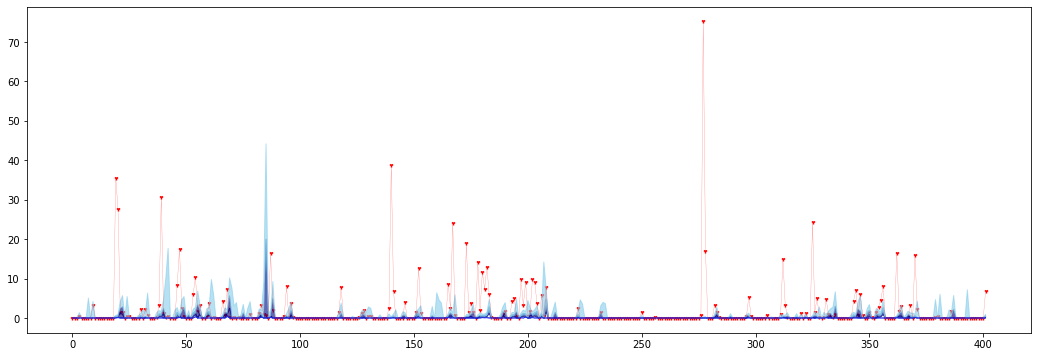

In [24]:
#for location id 0

q_05fitted=[ sorted(sim_rain_1000[i][0])[49] for i in range(402)]
q_25fitted=[ sorted(sim_rain_1000[i][0])[249] for i in range(402)]
q_50fitted=[ sorted(sim_rain_1000[i][0])[499] for i in range(402)]
q_75fitted=[ sorted(sim_rain_1000[i][0])[749] for i in range(402)]
q_95fitted=[ sorted(sim_rain_1000[i][0])[949] for i in range(402)]

plt.figure(figsize=(18, 6))
plt.scatter([i for i in range(402)],gamma_allcities[0][5][index_for_overlapdays[0]],color='r',marker='1',s=16)
plt.plot(gamma_allcities[0][5][index_for_overlapdays[0]],color='r',alpha=0.5,linewidth=0.3)
plt.plot(q_05fitted,color='skyblue',linewidth=0.6,alpha=0.3)
plt.plot(q_25fitted,color='navy',linewidth=0.6,alpha=0.3)
plt.plot(q_05fitted,color='blue',linewidth=1,alpha=1)
plt.plot(q_05fitted,color='navy',linewidth=0.6,alpha=0.3)
plt.plot(q_05fitted,color='skyblue',linewidth=0.6,alpha=0.3)
plt.fill_between([i for i in range(402)], q_50fitted, q_75fitted, where=([q_50fitted[k] < q_75fitted[k] for k in range(402)]), color='navy', alpha=0.6,interpolate=True)
plt.fill_between([i for i in range(402)], q_50fitted, q_25fitted, where=([q_50fitted[k] > q_25fitted[k] for k in range(402)]), color='navy', alpha=0.6,interpolate=True)
plt.fill_between([i for i in range(402)], q_95fitted, q_75fitted, where=([q_95fitted[k] > q_75fitted[k] for k in range(402)]), color='skyblue', alpha=0.6,interpolate=True)
plt.fill_between([i for i in range(402)], q_50fitted, q_75fitted, where=([q_05fitted[k] < q_25fitted[k] for k in range(402)]), color='skyblue', alpha=0.6,interpolate=True)

plt.show()


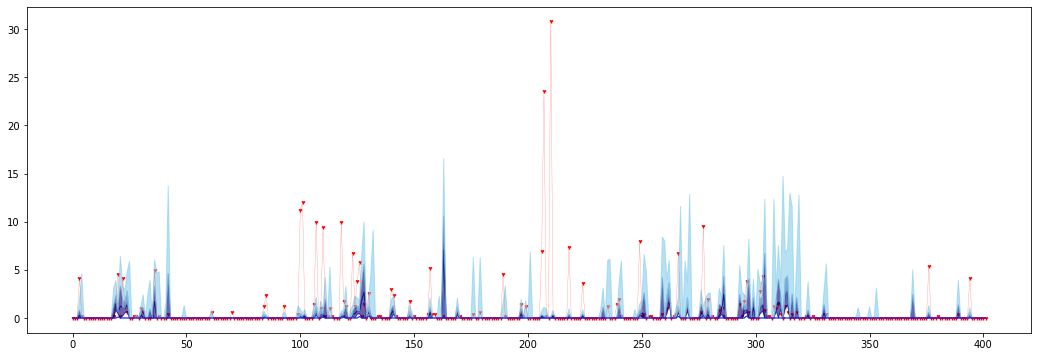

In [25]:
#for location id 16

q_05fitted=[ sorted(sim_rain_1000[i][1])[49] for i in range(402)]
q_25fitted=[ sorted(sim_rain_1000[i][1])[249] for i in range(402)]
q_50fitted=[ sorted(sim_rain_1000[i][1])[499] for i in range(402)]
q_75fitted=[ sorted(sim_rain_1000[i][1])[749] for i in range(402)]
q_95fitted=[ sorted(sim_rain_1000[i][1])[949] for i in range(402)]

plt.figure(figsize=(18, 6))
plt.scatter([i for i in range(402)],gamma_allcities[16][5][index_for_overlapdays[1]],color='r',marker='1',s=16)
plt.plot(gamma_allcities[16][5][index_for_overlapdays[1]],color='r',alpha=0.5,linewidth=0.3)
plt.plot(q_05fitted,color='skyblue',linewidth=0.6,alpha=0.3)
plt.plot(q_25fitted,color='navy',linewidth=0.6,alpha=0.3)
plt.plot(q_05fitted,color='blue',linewidth=1,alpha=1)
plt.plot(q_05fitted,color='navy',linewidth=0.6,alpha=0.3)
plt.plot(q_05fitted,color='skyblue',linewidth=0.6,alpha=0.3)
plt.fill_between([i for i in range(402)], q_50fitted, q_75fitted, where=([q_50fitted[k] < q_75fitted[k] for k in range(402)]), color='navy', alpha=0.6,interpolate=True)
plt.fill_between([i for i in range(402)], q_50fitted, q_25fitted, where=([q_50fitted[k] > q_25fitted[k] for k in range(402)]), color='navy', alpha=0.6,interpolate=True)
plt.fill_between([i for i in range(402)], q_95fitted, q_75fitted, where=([q_95fitted[k] > q_75fitted[k] for k in range(402)]), color='skyblue', alpha=0.6,interpolate=True)
plt.fill_between([i for i in range(402)], q_50fitted, q_75fitted, where=([q_05fitted[k] < q_25fitted[k] for k in range(402)]), color='skyblue', alpha=0.6,interpolate=True)

plt.show()

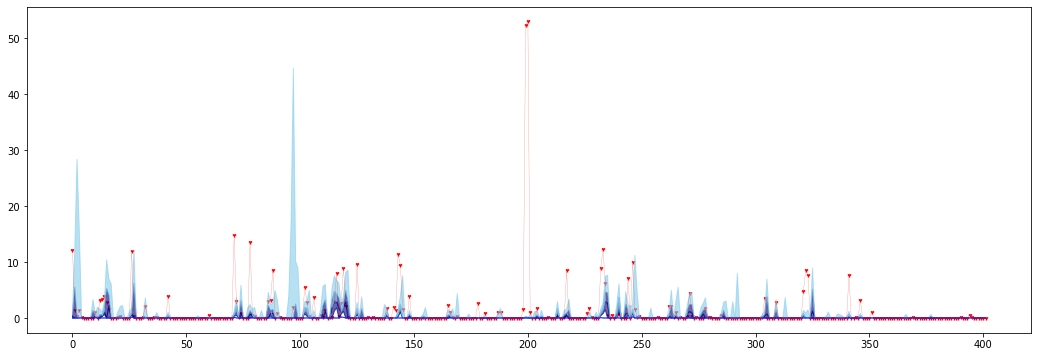

In [28]:
#for location id 19

q_05fitted=[ sorted(sim_rain_1000[i][2])[49] for i in range(402)]
q_25fitted=[ sorted(sim_rain_1000[i][2])[249] for i in range(402)]
q_50fitted=[ sorted(sim_rain_1000[i][2])[499] for i in range(402)]
q_75fitted=[ sorted(sim_rain_1000[i][2])[749] for i in range(402)]
q_95fitted=[ sorted(sim_rain_1000[i][2])[949] for i in range(402)]

plt.figure(figsize=(18, 6))
plt.scatter([i for i in range(402)],gamma_allcities[19][5][index_for_overlapdays[2]],color='r',marker='1',s=16)
plt.plot(gamma_allcities[19][5][index_for_overlapdays[2]],color='r',alpha=0.5,linewidth=0.3)
plt.plot(q_05fitted,color='skyblue',linewidth=0.6,alpha=0.3)
plt.plot(q_25fitted,color='navy',linewidth=0.6,alpha=0.3)
plt.plot(q_05fitted,color='blue',linewidth=1,alpha=1)
plt.plot(q_05fitted,color='navy',linewidth=0.6,alpha=0.3)
plt.plot(q_05fitted,color='skyblue',linewidth=0.6,alpha=0.3)
plt.fill_between([i for i in range(402)], q_50fitted, q_75fitted, where=([q_50fitted[k] < q_75fitted[k] for k in range(402)]), color='navy', alpha=0.6,interpolate=True)
plt.fill_between([i for i in range(402)], q_50fitted, q_25fitted, where=([q_50fitted[k] > q_25fitted[k] for k in range(402)]), color='navy', alpha=0.6,interpolate=True)
plt.fill_between([i for i in range(402)], q_95fitted, q_75fitted, where=([q_95fitted[k] > q_75fitted[k] for k in range(402)]), color='skyblue', alpha=0.6,interpolate=True)
plt.fill_between([i for i in range(402)], q_50fitted, q_75fitted, where=([q_05fitted[k] < q_25fitted[k] for k in range(402)]), color='skyblue', alpha=0.6,interpolate=True)
#for example taking plt.xlim([50,150]) you can see that the model is learing something
plt.show()

In [ ]:
# Next:

# stil need to do:

# get 10 to 16 locations with most overlap in the bottom right corner
# fit for them, and sim and plot